In [74]:
# importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
import datetime
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd

In [50]:
df = pd.read_csv('ads_hour.csv',
                 index_col=['Date'], parse_dates=['Date'])

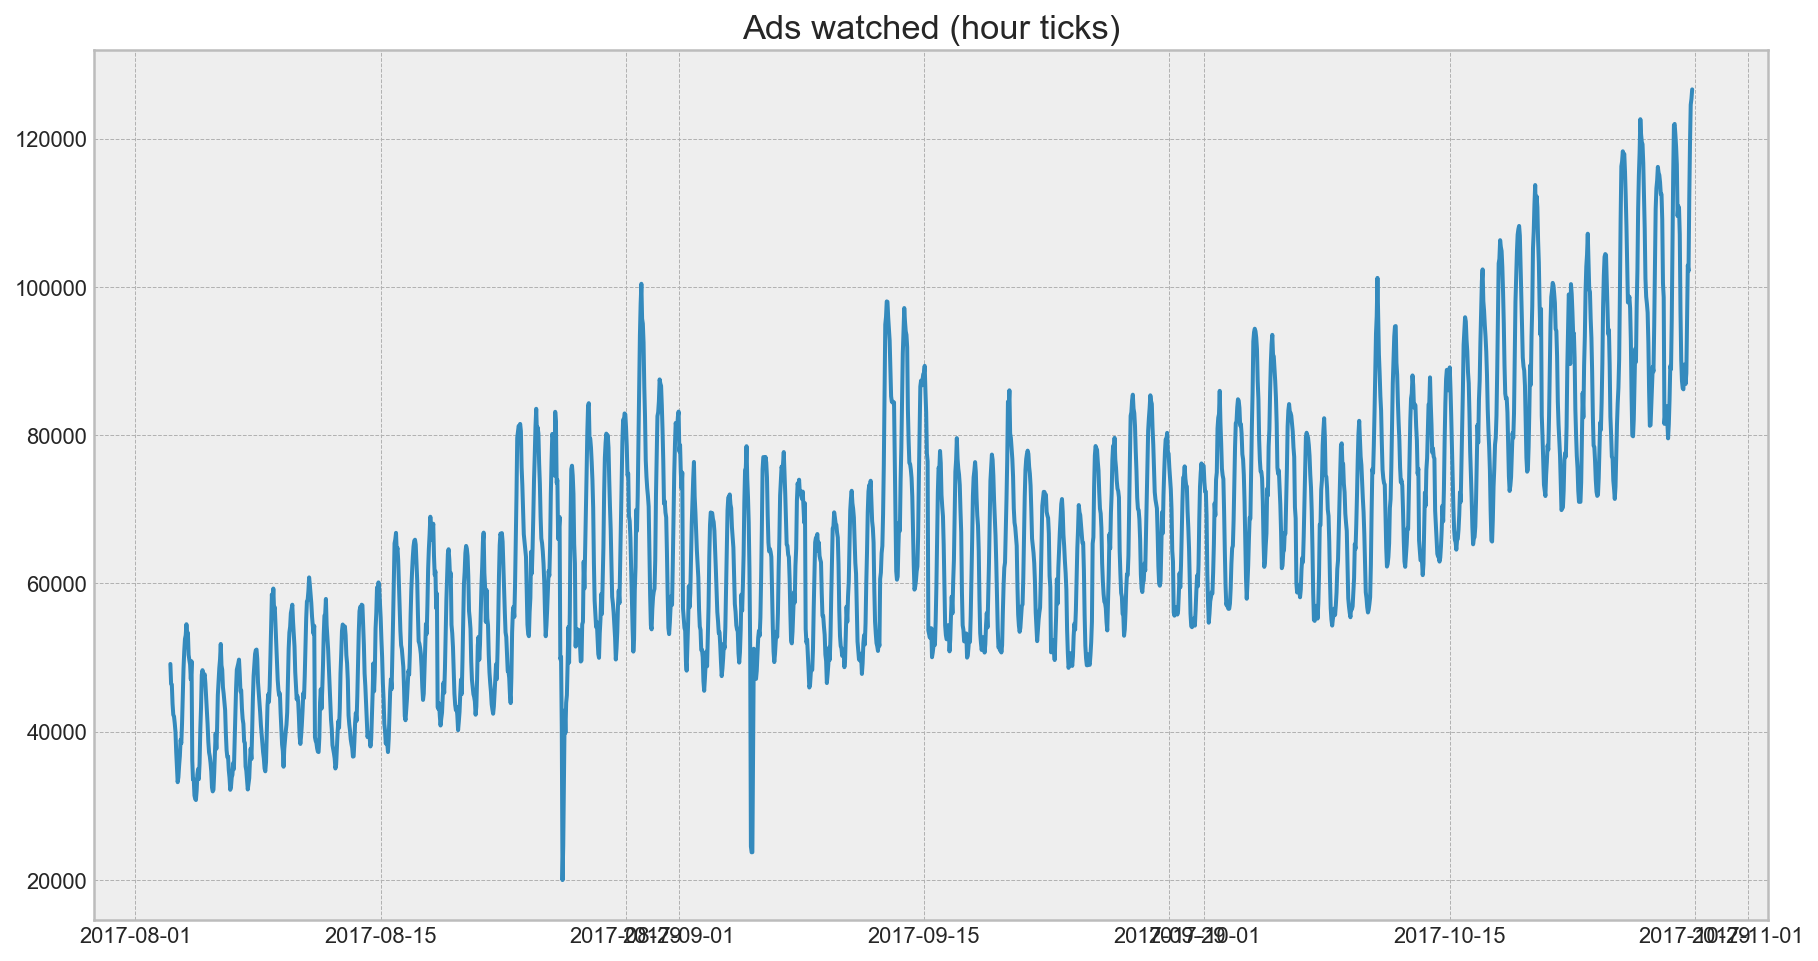

In [51]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

In [52]:
df.head()

,ads
Date,
2017-08-03 00:00:00,49136
2017-08-03 01:00:00,46450
2017-08-03 02:00:00,46355
2017-08-03 03:00:00,43748
2017-08-03 04:00:00,42281


In [53]:
scaler = MinMaxScaler()
df.ads = scaler.fit_transform(df.ads.to_numpy().reshape(-1,1))

In [54]:
def prepareData(data,n_steps = 50, test_size=0.20):
    """
    series: pd.DataFrame
        dataframe with timeseries

    lag_start: int
        initial step back in time to slice target variable 
        example - lag_start = 1 means that the model 
                  will see yesterday's values to predict today

    lag_end: int
        final step back in time to slice target variable
        example - lag_end = 4 means that the model 
                  will see up to 4 days back in time to predict today

    test_size: float
        size of the test dataset after train/test split as percentage of dataset

    """
    data = pd.DataFrame(data.copy())
    data.columns = ["ads"]
    
    # adding lags of original time series data as features
#     for i in range(lag_start, lag_end):
#         data["lag_{}".format(i)] = data.y.shift(i)
        
    # transforming df index to datetime and creating new variables
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
        
    # since we will be using only linear models we need to get dummies from weekdays 
    # to avoid imposing weird algebraic rules on day numbers
    data = pd.concat([
        data.drop("weekday", axis=1), 
        pd.get_dummies(data['weekday'], prefix='weekday')
    ], axis=1)
        
    # encode hour with sin/cos transformation
    # credits - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    data['sin_hour'] = np.sin(2*np.pi*data['hour']/24)
    data['cos_hour'] = np.cos(2*np.pi*data['hour']/24)
    data.drop(["hour"], axis=1, inplace=True)
        
    
    data = data.dropna()
    data = data.reset_index(drop=True)
    size = data.shape[0]-n_steps-9
    
    serie = np.empty((size, n_steps+10, 10))
    for i in range(size):
        serie[i,:,:] = data[i:i+n_steps+10]

    X = serie[:, :n_steps]
    Y = np.empty((size, n_steps, 10))
    for step_ahead in range(1, 10 + 1):
        Y[:, :, step_ahead - 1] = serie[:, step_ahead:step_ahead + n_steps, 0]     
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,shuffle=False ,random_state=42)
    return X_train, X_test, Y_train, Y_test

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
X_train, X_test, y_train, y_test = prepareData(df)

In [56]:
X_train.shape,y_train.shape

((1620, 50, 10), (1620, 50, 10))

In [57]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 10]),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse],use_multiprocessing=True)

In [58]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Train on 1620 samples, validate on 406 samples
Epoch 1/20
1620/1620 [==============================] - 2s 1ms/sample - loss: 0.0688 - last_time_step_mse: 0.0636 - val_loss: 0.0668 - val_last_time_step_mse: 0.0494
Epoch 2/20
1620/1620 [==============================] - 0s 211us/sample - loss: 0.0137 - last_time_step_mse: 0.0078 - val_loss: 0.0548 - val_last_time_step_mse: 0.0455
Epoch 3/20
1620/1620 [==============================] - 0s 209us/sample - loss: 0.0100 - last_time_step_mse: 0.0056 - val_loss: 0.0408 - val_last_time_step_mse: 0.0338
Epoch 4/20
1620/1620 [==============================] - 0s 200us/sample - loss: 0.0080 - last_time_step_mse: 0.0045 - val_loss: 0.0275 - val_last_time_step_mse: 0.0208
Epoch 5/20
1620/1620 [==============================] - 0s 203us/sample - loss: 0.0064 - last_time_step_mse: 0.0035 - val_loss: 0.0200 - val_last_time_step_mse: 0.0132
Epoch 6/20
1620/1620 [==============================] - 0s 202us/sample - loss: 0.0051 - last_time_step_mse: 0.0026

(3015.8244400400245, 3.4492527938234563)

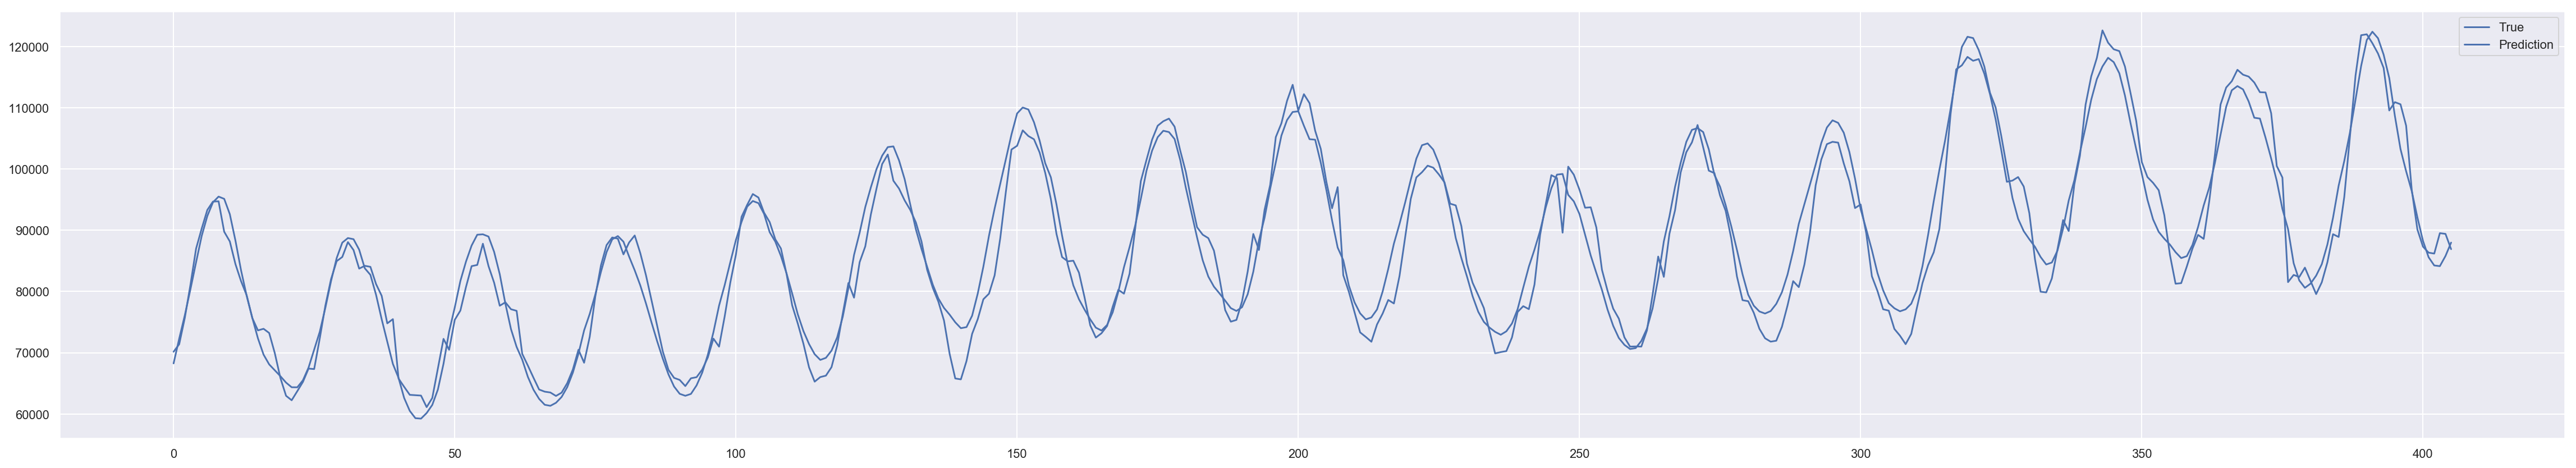

In [79]:
pred = model.predict(X_test)
pred1 = np.empty((525))
pred1 = scaler.inverse_transform(pred[:,49,0].reshape(-1,1))
y1 = scaler.inverse_transform(y_test[:,49,0].reshape(-1,1))

plt.figure(figsize=(40,7))
sns.lineplot(data=y1)
sns.lineplot(data=pred1)
plt.legend(labels=['True','Prediction'])
mae  = mean_absolute_error(pred1, y1)
mape = mean_absolute_percentage_error(pred1, y1)
mae,mape

Text(0.5, 1.0, 'MAE 2458.0, MAPE 3.8%')

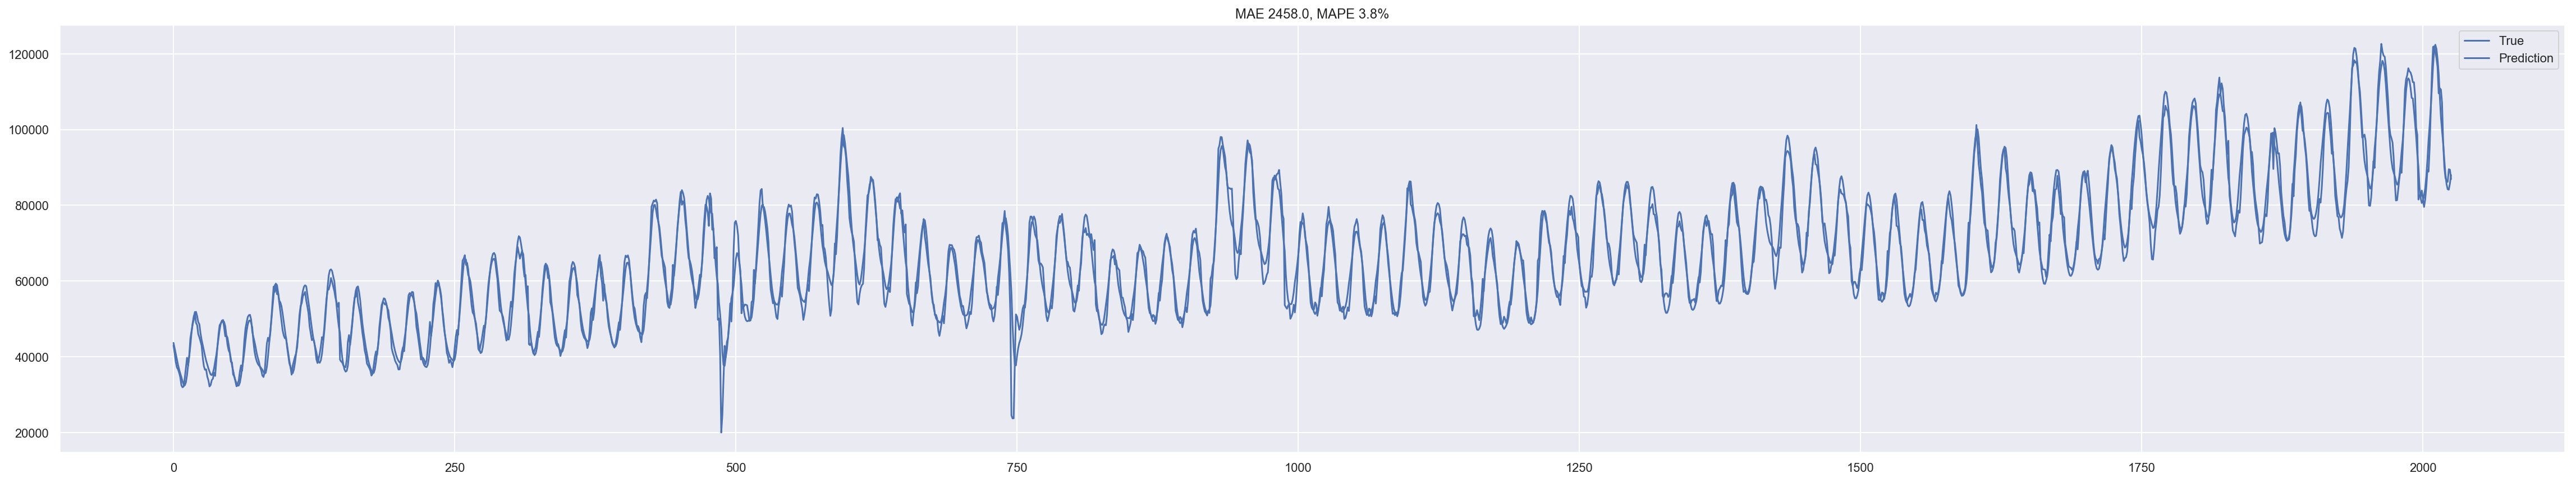

In [69]:
X= np.concatenate((X_train,X_test),axis=0)
full_pred=model.predict(X)
plt.figure(figsize=(40,7))
nb_input = 50
steps_ahead = 1
Y = np.concatenate((y_train,y_test),axis=0)
plt_Y = scaler.inverse_transform(Y[:,nb_input-1,steps_ahead-1].reshape(-1,1))
plt_pred = scaler.inverse_transform(full_pred[:,nb_input-1,steps_ahead-1].reshape(-1,1))

mae  = mean_absolute_error(plt_pred, plt_Y)
mape = mean_absolute_percentage_error(plt_pred, plt_Y)

sns.lineplot(data=plt_Y)
sns.lineplot(data=plt_pred)
plt.legend(labels=['True','Prediction'])
plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))